In [1]:
# importing all the libraries we need
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
import os
import torch
from torchvision import datasets,transforms,models
from torch import optim,cuda
import torch.nn as nn
from torch.utils.data import DataLoader,sampler,random_split
from PIL import Image

In [2]:
# Knowing the data 
classes = []
num_imgs = []

data_dir = "./natural_images/"

for folder in os.listdir(data_dir):
    classes.append(folder)
    num_imgs.append(len(os.listdir(data_dir+folder)))
    
df = pd.DataFrame({"class":classes,'size':num_imgs})
df    

,class,size
0,airplane,727
1,car,968
2,cat,885
3,dog,702
4,flower,843
5,fruit,1000
6,motorbike,788
7,person,986


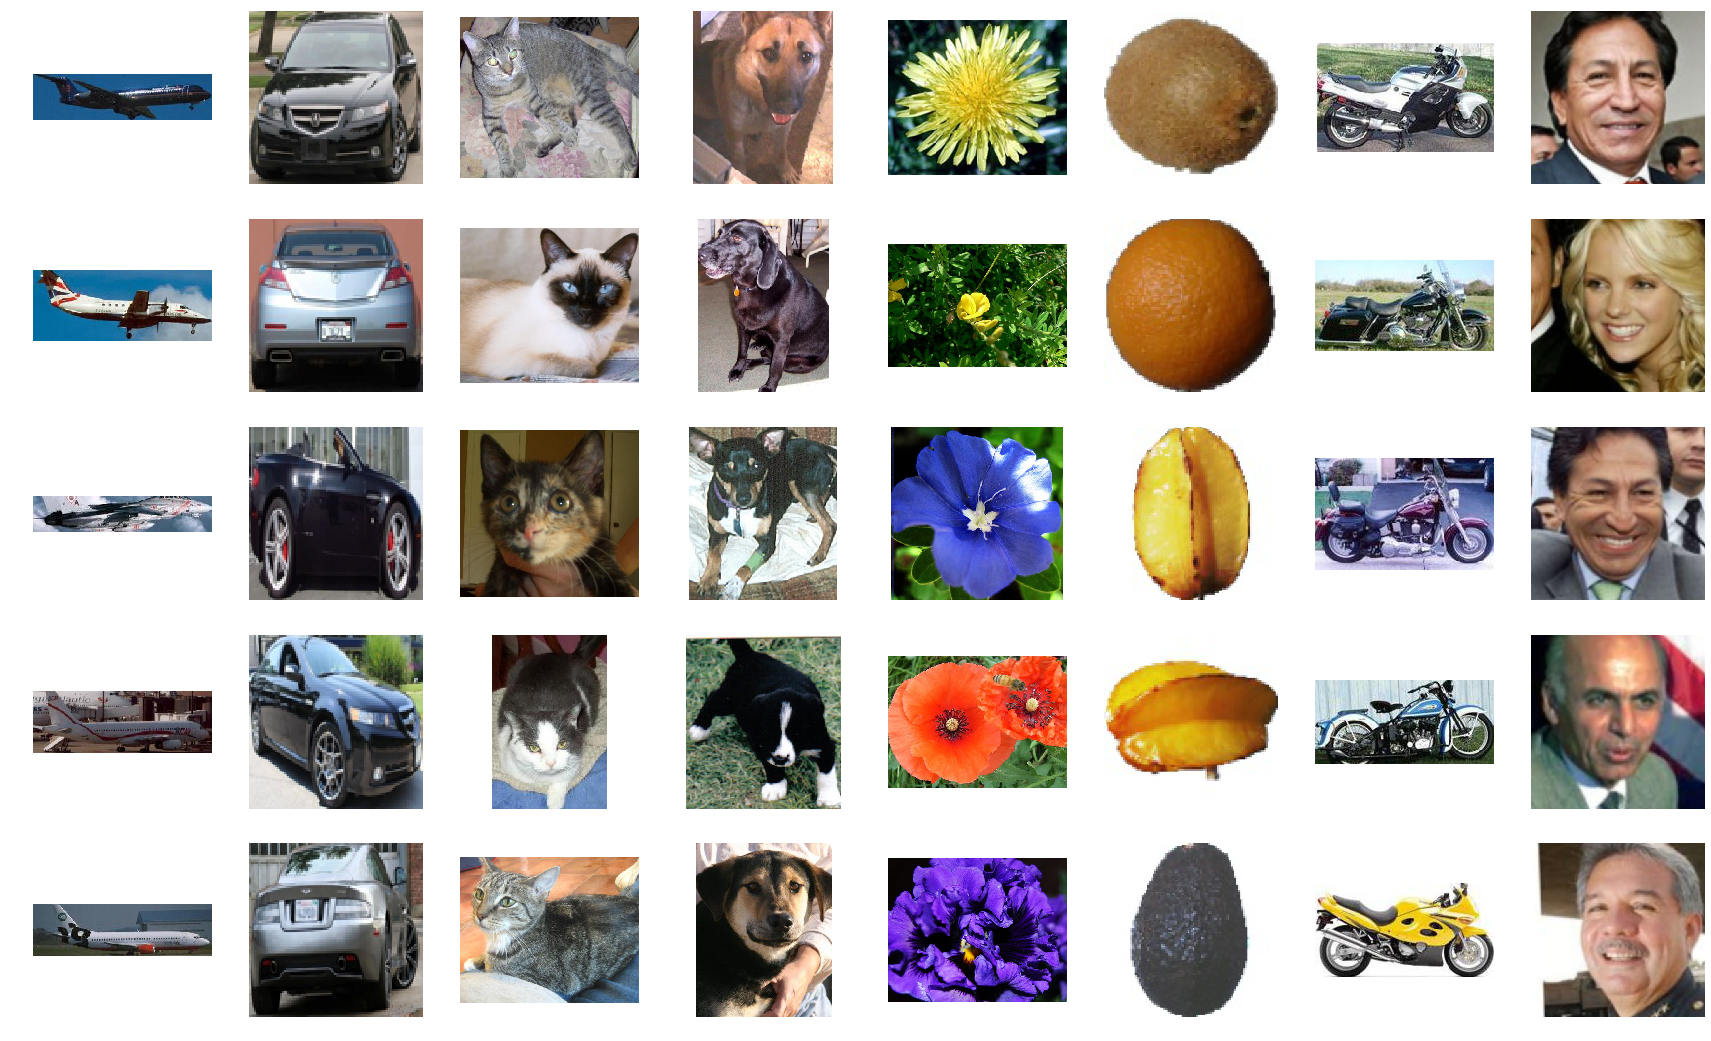

In [3]:
sample = []
num_imgs_per_class = 5
for i in range(num_imgs_per_class):
    for folder in os.listdir(data_dir):
        sample.append(os.path.join(data_dir+folder+"/",random.choice(os.listdir(data_dir+folder+"/"))))

# plotting some images to know the data
plt.figure(figsize=(30,30))
for n in range(len(sample)):
  plt.subplot(8,8,n+1)
  plt.imshow(Image.open(sample[n]))
  plt.axis('off')

In [4]:
# loading the model architecture
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [5]:
# freezing all the parameters from training 
for param in model.parameters():
    param.requires_grad = False

# adding a fc layer with relu activation and a dropout layer to prevent overfitting then output layer with num of classes
num_class = 8
model.fc = nn.Sequential(nn.Linear(model.fc.in_features,1024),
                         nn.ReLU(),
                         nn.Dropout(0.4),
                         nn.Linear(1024,num_class),
                         nn.LogSoftmax(dim=1))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
# doing data augmentation 
train_transform = transforms.Compose([transforms.RandomRotation(45),transforms.RandomVerticalFlip(),
                                     transforms.RandomHorizontalFlip,transforms.Resize((224,224)),
                                    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.RandomRotation(45),transforms.RandomVerticalFlip(),
                                     transforms.RandomHorizontalFlip,transforms.Resize((224,224)),
                                    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [7]:
# splitting the data into train/validation/test sets
dataset = datasets.ImageFolder(data_dir)
train_data_len = int(len(dataset)*0.8)
val_data_len = int((len(dataset) - train_data_len)*0.75)
test_data_len = int(len(dataset) - train_data_len - val_data_len)

train_data,val_data,test_data = random_split(dataset,[train_data_len,val_data_len,test_data_len])

train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform
test_data.dataset.transform = test_transform

print("train len: ",len(train_data),"\nval len: ",len(val_data),"\ntest len: ",len(test_data))

train len:  5519 
val len:  1035 
test len:  345


In [8]:
# loading the data into data loader
batch_size = 128

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [9]:
#check whether we can use the gpu or not 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [10]:
def train(model,criterion,optimizer,num_epochs=10):
    start = time.time()
    best_model = model.state_dict()
    best_acc = 0.0
    loss_over_time_train = []
    loss_over_time_val = []
    acc_over_time_train = []
    acc_over_time_val = []
    
    for epoch in range(num_epochs):
        print("{}/{}".format(epoch+1,epochs))
        
        # each epoch has a training and validation phase
        for phase in ['train','valid']:
            if phase == 'train':
                model.train()             # set the model to train mode
                dataLoader = train_loader
            else:
                model.eval()             # set the model to evaluate mode
                dataLoader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over the data
            # Iterate over data.
            for data in dataLoader:
                # get the inputs
                inputs, labels = data

                inputs=inputs.to(device)
                labels=labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs,labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # calculating the loss and accuracy
                running_loss  += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase=="train":
                epoch_loss = running_loss / len(train_data)
                loss_over_time_train.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(train_data)
                acc_over_time_train.append(epoch_acc)
    
                
            else:
                epoch_loss = running_loss / len(val_data)
                loss_over_time_val.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(val_data)
                acc_over_time_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model =model.state_dict()
            
        print('-' * 60)
                    
    total_time = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        total_time // 60, total_time % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model)
    loss = {"train":loss_over_time_train,"val":loss_over_time_val}
    acc = {"train":acc_over_time_train,"val":acc_over_time_val}
    return model,loss,acc    

In [11]:
# training the model
epochs = 6
trained_model,loss,acc = train(model,criterion=criterion,optimizer=optimizer,num_epochs=epochs)

1/6
train Loss: 0.6660 Acc: 0.9128
valid Loss: 0.0843 Acc: 0.9961
------------------------------------------------------------
2/6
train Loss: 0.0585 Acc: 0.9960
valid Loss: 0.0339 Acc: 0.9971
------------------------------------------------------------
3/6
train Loss: 0.0321 Acc: 0.9971
valid Loss: 0.0222 Acc: 0.9961
------------------------------------------------------------
4/6
train Loss: 0.0235 Acc: 0.9971
valid Loss: 0.0189 Acc: 0.9981
------------------------------------------------------------
5/6
train Loss: 0.0164 Acc: 0.9986
valid Loss: 0.0158 Acc: 0.9981
------------------------------------------------------------
6/6
train Loss: 0.0141 Acc: 0.9982
valid Loss: 0.0125 Acc: 0.9981
------------------------------------------------------------
Training complete in 5m 6s
Best val Acc: 0.998068


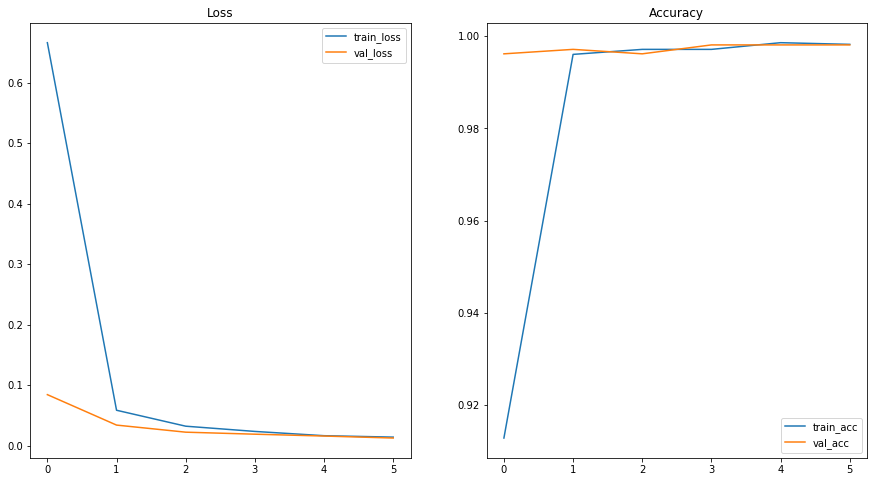

In [12]:
# plotting the loss and accuracy curve for each phase
train_loss = loss['train']
val_loss = loss['val']
train_acc = acc['train']
val_acc = acc['val']

epochs_range = range(epochs)

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(epochs_range,train_loss,label="train_loss")
plt.plot(epochs_range,val_loss,label="val_loss")
plt.legend(loc=0)
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epochs_range,train_acc,label="train_acc")
plt.plot(epochs_range,val_acc,label="val_acc")
plt.legend(loc=0)
plt.title("Accuracy")

plt.show()

In [13]:
# the model's name
model_name = "./ResNet50_01.pt"
# saving the best trained model
torch.save(model.state_dict(),model_name)

In [14]:
# loading the model to evaluate
model.load_state_dict(torch.load("ResNet50_01.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
# testing how good the model is
def testing(model,criterion):
    
    model.eval()       # setting the model to evaluate mode
    test_loss = 0.0
    test_acc = 0.0
    
    for inputs,labels in test_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # predicting
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        _,pred = torch.max(outputs,dim=1)
        
        # calculating the loss and accuracy 
        test_loss += loss.item()*inputs.size(0)        
        correct = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct.type(torch.FloatTensor))
        test_acc += accuracy.item() * inputs.size(0)
    
    # avreging the loss and accuracy
    test_loss = test_loss/len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)
        
    print("test loss: {:.4f}  test acc: {:.4f}".format(test_loss,test_acc))

In [16]:
# testing the model
testing(model,criterion)

test loss: 0.0204  test acc: 0.9971


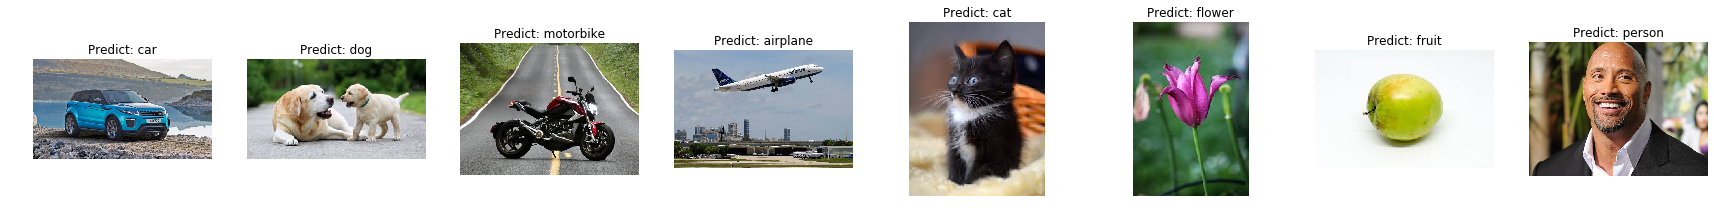

In [17]:
# reading some images from the web
lo_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
lo_data = datasets.ImageFolder("./lo",transform=lo_transform)
lo_loader = DataLoader(lo_data,batch_size=1)

# predicting the images
preds = []
for inputs,labels in lo_loader:
        
    inputs = inputs.to(device)
        
    outputs = model(inputs)
    _,pred = torch.max(outputs,dim=1)
    preds.append(classes[pred])

# plotting the images and its prediction
lo_dir = "./lo/"
imgs = []
for folder in os.listdir(lo_dir):
    for i in os.listdir(lo_dir+folder):
        imgs.append(os.path.join(lo_dir+folder+"/",i))

plt.figure(figsize=(30,30))
for n in range(len(imgs)):
    plt.subplot(8,8,n+1)
    plt.imshow(Image.open(imgs[n]))
    plt.title("Predict: "+preds[n])
    plt.axis('off')